In [1]:
!rm -rf InkubaLM-Challenge
!git clone https://github.com/melissafasol/InkubaLM-Challenge.git
%cd InkubaLM-Challenge


Cloning into 'InkubaLM-Challenge'...
remote: Enumerating objects: 520, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 520 (delta 69), reused 60 (delta 26), pack-reused 409 (from 1)
Receiving objects: 100% (520/520), 1.55 MiB | 5.88 MiB/s, done.
Resolving deltas: 100% (343/343), done.
/content/InkubaLM-Challenge


In [101]:
%cd InkubaLM-Challenge
!git pull


[Errno 2] No such file or directory: 'InkubaLM-Challenge'
/content/InkubaLM-Challenge
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 960 bytes | 240.00 KiB/s, done.
From https://github.com/melissafasol/InkubaLM-Challenge
   06bbc93..de64971  main       -> origin/main
Updating 06bbc93..de64971
Fast-forward
 utils/multitask.py | 61 +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
 1 file changed, 61 insertions(+)


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
!pip install -U trl bitsandbytes

In [4]:
!pip install datasets

In [5]:
import sys
from pathlib import Path


import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from datasets import (
    load_dataset,
    concatenate_datasets,
    Dataset,
    Value
)
from huggingface_hub import login
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    PeftModel
)
from trl import (
    SFTConfig,
    SFTTrainer,
    DataCollatorForCompletionOnlyLM
)

from utils import (
    eval,
    model_function,
    supplement,
    multitask,
    ab_testing
)


In [6]:
from google.colab import drive
drive.mount('/content/drive')
output_path = "/content/drive/MyDrive/InkubaLM-Challenge/Output"
os.makedirs(output_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from huggingface_hub import login

try:
    from google.colab import userdata
    os.environ["hf_token_2"] = userdata.get("hf_token_2")
except:
    os.environ["hf_token_2"] = "----"

login(token=os.environ["hf_token_2"])

token = os.environ["hf_token_2"]
if token == "----":
    print("⚠️ Warning: No Hugging Face token found. Some models may not load.")
else:
    login(token=token)

In [8]:
hf_token_2 = '...'
os.environ["HF_TOKEN"] = hf_token_2

## **Load and Explore Datasets**

In [9]:
print("# Loading datasets")
se_dataset, mt_dataset,xn_dataset = multitask.load_and_combine_datasets("Train")
test_dataset = multitask.load_and_combine_datasets("Test")


# Loading datasets


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/72.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/600 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/400 [00:00<?, ? examples/s]

All Columns: ['ID', 'langs', 'targets', 'instruction', 'data_source', 'premise', 'task', 'inputs']


Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/486 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/484 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/22.4k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/447 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/300 [00:00<?, ? examples/s]

All Columns: ['ID', 'langs', 'targets', 'instruction', 'data_source', 'premise', 'task', 'inputs']


Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/300 [00:00<?, ? examples/s]

In [41]:
se_df = pd.DataFrame(se_dataset)
mt_df = pd.DataFrame(mt_dataset)
xn_df = pd.DataFrame(xn_dataset)

hau_se_df = se_df.loc[se_df['langs'] == 'hausa']
swa_se_df = se_df.loc[se_df['langs'] == 'swahili']

hau_xnli_df = xn_df.loc[xn_df['langs'] == 'hau']
swa_xnli_df = xn_df.loc[xn_df['langs'] == 'swa']

In [37]:
print(hau_xnli_df['targets'].value_counts())

targets
0    67
2    67
1    66
Name: count, dtype: int64


In [38]:
hau_xnli_df

,ID,langs,premise,inputs,instruction,targets,data_source,task
0,ID_648d37ff_dev_afrixnli_hau,hau,"Kuma kawai sai naji Hakane, wannan din ne.","Bayan nace e, ya ƙare.","Is the following question True, False or Neither?",0,,
1,ID_f96a39cb_dev_afrixnli_hau,hau,"Eh, Eh, na sani, ba zan ma damu sosai ba idan ...",Ba zan damu ba idan ɗaukan nauyin kuɗin da ake...,"Is the following question True, False or Neither?",0,,
3,ID_99a61e3d_dev_afrixnli_hau,hau,"Kuma kawai sai naji Hakane, wannan din ne.",Nace a'a amma yaci gaba da ja-in-ja.,"Is the following question True, False or Neither?",2,,
6,ID_8b5c4722_dev_afrixnli_hau,hau,Lokacin da wayayyiyar al'umma suka toshe kunna...,Shirme zasu ragu idan wayayyiyar al'umma sunyi...,"Is the following question True, False or Neither?",0,,
8,ID_d40fc996_dev_afrixnli_hau,hau,"Ina ganin zai yi yi, ina tunanin hakan, ban da...","Ina da adawa mai karfi akan gwajin kwaya, bani...","Is the following question True, False or Neither?",2,,
...,...,...,...,...,...,...,...,...
389,ID_312afeeb_dev_afrixnli_hau,hau,Lokacin da wayayyiyar al'umma suka toshe kunna...,Shirme yana samun karɓuwa wajan wayayyiyar al'...,"Is the following question True, False or Neither?",2,,
390,ID_08c49dc6_dev_afrixnli_hau,hau,Ina wajen dai kawai ina ƙoƙarin gano shi.,Ina ƙoƙarin ganewa.,"Is the following question True, False or Neither?",0,,
392,ID_1f92163a_dev_afrixnli_hau,hau,Sauwaƙaƙe layikan dake jikin Sant Pau an yadda...,Sant Pau na da zanan gidajen da.,"Is the following question True, False or Neither?",0,,
397,ID_b871ea53_dev_afrixnli_hau,hau,Ka damu da yadda labarun ƙasa ke shafar unguwa...,Ban damu ba da abinda labarun ƙasa ke nuni cik...,"Is the following question True, False or Neither?",2,,


In [44]:
print(swa_xnli_df['targets'].value_counts())

targets
True       67
False      67
Neither    66
Name: count, dtype: int64


In [11]:
print(hau_se_df['targets'].value_counts())
print(swa_se_df['targets'].value_counts())

targets
Korau          72
Tsaka-tsaki    67
Kyakkyawa      61
Name: count, dtype: int64
targets
Wastani    124
Chanya      48
Hasi        28
Name: count, dtype: int64


# **Data Augmentation**

###**Problem:** sentiment analysis classes are heavily skewed towards neutral class for Swahili.

### **Solution**: supplement dataset with various augmentation techniques:
- **synonym replacement**
- **random swap**
- **random deletion** (produces data that is more similar to social media posts)

In [45]:
xn_df['task'] = 'afrixnli'
mt_df['task'] = 'mt'

In [46]:
df = se_df
df["is_augmented"] = False


augmented_rows = []
for _, row in df.iterrows():
    aug = supplement.apply_augmentation(row, supplement.synonyms_sent, lang_key_map = supplement.lang_map_sent)
    if aug is not None:
        augmented_rows.append(aug)

augmented_df = pd.DataFrame(augmented_rows)

sent_aug_df = pd.concat([se_df, augmented_df], ignore_index=True)

In [54]:
df = xn_df
df["is_augmented"] = False


augmented_rows = []
for _, row in df.iterrows():
    aug = supplement.apply_augmentation(row, supplement.synonyms_xnli, lang_key_map = supplement.lang_map_sent)
    if aug is not None:
        augmented_rows.append(aug)

augmented_df = pd.DataFrame(augmented_rows)

xnli_aug_df = pd.concat([xn_df, augmented_df], ignore_index=True)

In [55]:
label_map = {
    0: "True",
    1: "Neither",
    2: "False"
}

xnli_aug_df["targets"] = xnli_aug_df["targets"].astype(int).map(label_map)


In [56]:
train_df_concat = pd.concat([xnli_aug_df, sent_aug_df, mt_df], axis=0)
train_df_concat = train_df_concat.drop(columns=["is_augmented"], errors="ignore")

In [57]:
train_df_concat.head()

,ID,langs,premise,inputs,instruction,targets,data_source,task
0,ID_648d37ff_dev_afrixnli_hau,hau,"Kuma kawai sai naji Hakane, wannan din ne.","Bayan nace e, ya ƙare.","Is the following question True, False or Neither?",True,,afrixnli
1,ID_f96a39cb_dev_afrixnli_hau,hau,"Eh, Eh, na sani, ba zan ma damu sosai ba idan ...",Ba zan damu ba idan ɗaukan nauyin kuɗin da ake...,"Is the following question True, False or Neither?",True,,afrixnli
2,ID_4c5d953b_dev_afrixnli_swa,swa,"Alafu, hakuelewa kabisa.","Alas, hakuweza kuelewa wazi kutokana na kizuiz...","Is the following question True, False or Neither?",Neither,,afrixnli
3,ID_99a61e3d_dev_afrixnli_hau,hau,"Kuma kawai sai naji Hakane, wannan din ne.",Nace a'a amma yaci gaba da ja-in-ja.,"Is the following question True, False or Neither?",False,,afrixnli
4,ID_a38aa9d8_dev_afrixnli_swa,swa,Lakini siamini chombo chochote cha algorithmic...,Kanuni haziwezi kuamua jinsi ya kutengeneza mk...,"Is the following question True, False or Neither?",Neither,,afrixnli


In [58]:
print("\n# Applying target length balancing fix")
balanced_df = multitask.balance_target_lengths(train_df_concat)

print("\n# Analyzing target sequence lengths after balancing")
task_stats_after = multitask.analyze_task_lengths(balanced_df)



# Applying target length balancing fix

# Analyzing target sequence lengths after balancing
Target sequence length analysis by task:
Task: afrixnli
count    651.0
mean      11.0
std        0.0
min       11.0
25%       11.0
50%       11.0
75%       11.0
max       11.0
Name: targets, dtype: float64
--------------------------------------------------
Task: sentiment
count    632.0
mean      11.0
std        0.0
min       11.0
25%       11.0
50%       11.0
75%       11.0
max       11.0
Name: targets, dtype: float64
--------------------------------------------------
Task: mt
count    600.000000
mean      11.801667
std        8.347163
min        2.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       62.000000
Name: targets, dtype: float64
--------------------------------------------------


# **Balance Target Token Lengths**

The Lelapa AI Buzuzu-Mavi Challenge is a multitask learning problem because the model needs to be able to do sentiment analysis, natural language inference (XNLI) and machine translation.


If the target token lengths are not balanced, this will cause the model to **over-prioritise** longer tasks.


### **How can you fix this?**
- **Repeating short targets**: (e.g., "positive" → "positive positive positive...") to match the average target lenght of the reference task (in this case it is translation)
- This ensures that **all tasks contribute more equally** to the total training loss and the **model doesn't ignore short-output tasks** like classification.


In [59]:
print("\n# Applying target length balancing fix")
balanced_df = multitask.balance_target_lengths(train_df_concat)


# Applying target length balancing fix


In [60]:
balanced_dataset = Dataset.from_pandas(balanced_df.reset_index(drop=True))

In [61]:
model_name = "lelapa/InkubaLM-0.4B"
model, tokenizer, bnb_config = multitask.setup_model_and_tokenizer(model_name, token=token,use_4bit=False)

config.json:   0%|          | 0.00/763 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/960 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/991k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.95M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

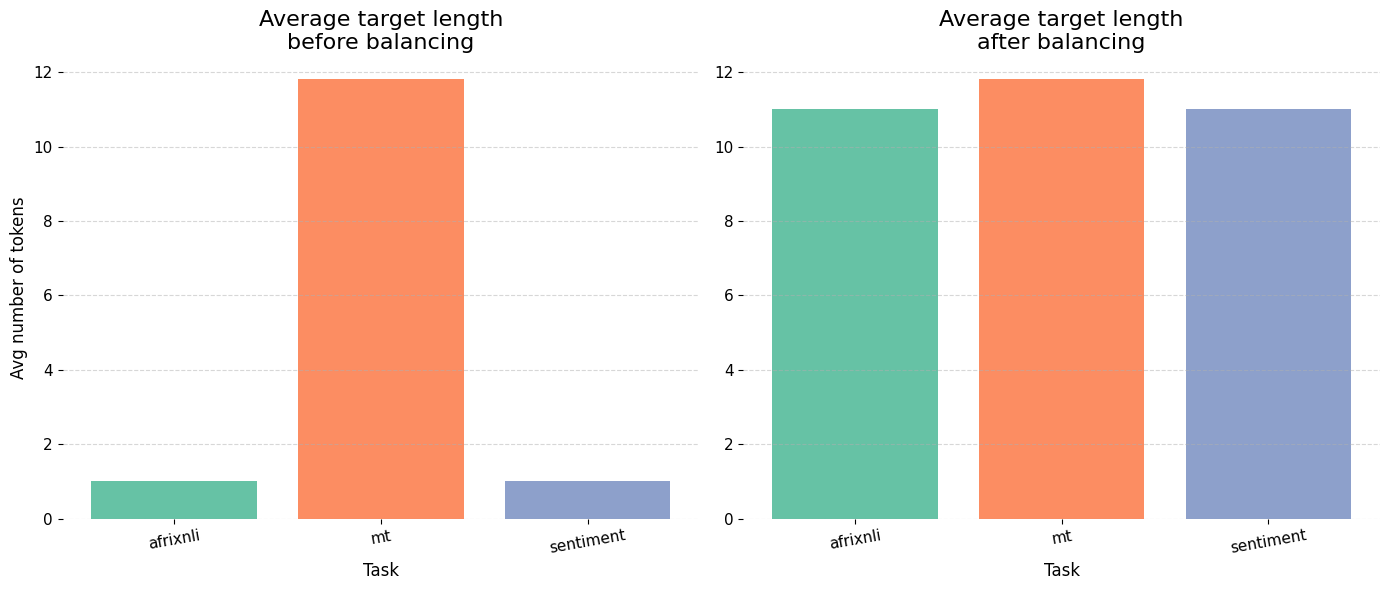

In [62]:
multitask.plot_target_lengths(train_df_concat, balanced_df)

In [63]:
balanced_trainer = multitask.setup_trainer(
    model=model,
    dataset=balanced_dataset,
    tokenizer=tokenizer,
    output_dir="./sft_model/balanced_xnli_target"
)
balanced_trainer.train()

Applying formatting function to train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Converting train dataset to ChatML:   0%|          | 0/1883 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1883 [00:00<?, ? examples/s]

Step,Training Loss
10,1.485600
20,1.331000
30,1.411000
40,1.710800
50,1.150400
60,1.252100
70,1.185900
80,1.320200
90,1.292600
100,1.329700


TrainOutput(global_step=351, training_loss=0.8048567777006035, metrics={'train_runtime': 956.7045, 'train_samples_per_second': 5.905, 'train_steps_per_second': 0.367, 'total_flos': 2380400228524032.0, 'train_loss': 0.8048567777006035})

In [64]:
output_dir = '/content/drive/MyDrive/InkubaLM/outputs/'

In [65]:
model.save_pretrained(os.path.join(output_dir, "sft_model/balanced/lora_adapter_v4"))
tokenizer.save_pretrained(os.path.join(output_dir, "sft_model/balanced/lora_adapter_v4"))


('/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/tokenizer_config.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/special_tokens_map.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/tokenizer.model',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/added_tokens.json',
 '/content/drive/MyDrive/InkubaLM/outputs/sft_model/balanced/lora_adapter_v4/tokenizer.json')

In [66]:
from datasets import concatenate_datasets

# Combine the tuple into a list
test_dataset_list = list(test_dataset)

# Concatenate all the datasets into one
combined_test_dataset = concatenate_datasets(test_dataset_list)

In [67]:
combined_test_dataset

Dataset({
    features: ['ID', 'task', 'langs', 'data_source', 'instruction', 'inputs', 'targets', 'premise'],
    num_rows: 900
})

In [102]:
v2_path = os.path.join(output_dir, "sft_model/balanced_supp/checkpoint-351-v4")
os.makedirs(v2_path, exist_ok=True)
inference_model = model.eval()
results_df = multitask.apply_inference_to_test_data_xnli_change(inference_model, tokenizer, combined_test_dataset)


Generating responses:   0%|          | 0/900 [00:00<?, ?it/s]

In [103]:
results_df[['ID', 'Response']].to_csv(os.path.join(output_dir,'submission_full_finetune_v4.csv'), index=False)
results = results_df[['ID', 'generated','Response']]

In [104]:

from google.colab import files

# Save your CSV
output_path = os.path.join(output_dir, 'submission_full_finetune_v4.csv')
results_df[['ID', 'Response']].to_csv(output_path, index=False)

# Download the file
files.download(output_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
submission_csv = results_df[['ID','Response']]